- 决策树对数据基本没有假设(例如：线性模型假设数据是线性的)，泛化能力强，更容易过拟合
- 非参数化模型，参数数量在训练之前是未知的
- `sklearn.tree.DecisionTreeClassifier`，限制决策树的最大深度 `max_depth`，增大参数列表中 `min_*` 参数，减小 `max_*` 参数都将正则化模型

计算复杂度：
* 做预测时，需要从根节点到叶节点横穿整根树，最大大概共$O(log_2(m))$个节点，每个节点只检查一个特征，计算复杂度即为$O(log_2(m))$
* 训练时，需要在所有节点上比较所有特征，计算复杂度$O(n*mlog(m))$,极大降低速度

    
黑箱模型：随机森林、神经网络等模型，很难清晰解释预测是怎么作出的

决策树是一个分而治之的递归过程。
- 构建根节点，将所有训练数据都放在根节点。
- 选择一个最优特征，按照这一特征将训练数据集分割成子集，使得各个子集有一个在当前条件下最好的分类。
- 如果子集未分类完毕，则在子集中选择一个最优特征，继续进行划分，直到所有训练数据子集都被正确分类或没有合适的特征为止。
                    
            
决策树三要素：
- 特征选择：从训练数据中众多的特征中选择一个特征作为当前节点的分裂标准，如何选择特征有着很多不同量化评估标准标准，从而衍生出不同的决策树算法。
- **决策树生成：**根据选择的特征评估标准，从上至下递归地生成子节点，直到数据集不可分则停止决策树停止生长。
- **决策树的修剪：**决策树容易过拟合，一般来需要剪枝，缩小树结构规模、缓解过拟合。剪枝技术有预剪枝和后剪枝两种。


有三种方法进行特征选择：`ID3`: 信息增益，`C4.5`: 信息增益比，`CART`: 基尼系数
1. `ID3`
    - 信息熵(`information entropy`)
$$\operatorname{Ent}(D)=-\sum_{k=1}^{|\mathcal{Y}|}p_k\log_{2}{p_k}$$
其中，$|\mathcal{Y}|$ 表示样本类别总数，$p_k$ 表示第 $k$ 类样本所占的比例
    - **信息增益(`information gain`)**
    $$\operatorname{Gain}(D,a) = \operatorname{Ent}(D) - \sum_{v=1}^{V}\frac{|D^v|}{|D|}\operatorname{Ent}({D^v})$$
    其中，属性 $a$ 有 $V$ 个取值，取值 $a^v$ 的样本数量 $D^v$
    - 一般来说，信息增益越大，意味着使用属性 $a$ 划分所获得纯度提升越大
    
    
    
2. `C4.5`
    - 信息增益准则对可取值数目较多的属性有所偏好，**增益率(`gain ratio`)**:
    $$\operatorname{Gain\_ratio}(D,a) = \frac{\operatorname{Gain}(D,a)}{\operatorname{IV}(a)}$$
    其中，$$\operatorname{IV}(a) = -\sum_{v=1}^{V}\frac{|D^v|}{|D|}\log_{2}{\frac{|D^v|}{|D|}}$$ 
    称为属性 $a$ 的固有值；属性 $a$ 的可能取值越多，该值越大。
    - 信息增益率对可能取值少的属性有所偏好；因此 C4.5 先从候选划分属性中找出信息增益高于平均水平的属性，再从中选择信息增益率最高的。
    
    
3. `CART`
    - 数据集 $D$ 的纯度可用基尼值来度量：
$$\begin{aligned}\operatorname{Gini}(p) &=\sum_{k=1}^{|y|}\sum_{{k'}\neq k}{p_k}{p_{k'}}\ &=1-\sum_{k=1}^{|y|}p_k^2 \end{aligned}$$
    $Gini(D)$ 反应了从数据集 $D$ 中随机抽取两个样本，其类别标记不一致的概率。$Gini(D)$ 越小，则 $D$ 的纯度越高
    - 基尼指数(`Gini index`)
    $$\operatorname{Gini\_index}(D,a) = \sum_{v=1}^{V}\frac{|D^v|}{|D|}\operatorname{Gini}(D^v)$$
    选择使得划分后基尼指数最小的属性作为最优划分属性
    - 找出最优树是一个`NP-complete`问题，需要$O(e^m)$时间复杂度；贪心算法，获得近似最优解
    

In [12]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / np.sum(hist)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


def gain(y, subsets):
    """
    y 根据某一指标划分后的子集
    """
    return entropy(y) - sum([len(sub_y) * entropy(sub_y)
                             for sub_y in subsets]) / len(y)

In [18]:
y = [0, 0, 0, 1, 1]
entropy(y)


0.9709505944546686

In [ ]:
def gain_ratio(y, subsets):
    n = len(y)
    iv = -sum([(len(subset) / n) * np.log2(len(subset) / n)
               for subset in subsets])
    return gain(y, subsets) / iv

In [5]:
def gini(y):
    hist = np.bincount(y)
    N = np.sum(hist)
    return 1 - sum([(i / N) for i in hist])


def gini_index(y, subsets):
    return np.sum([(len(subset) / len(y)) * gini(subset)
                   for subset in subsets])

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
model.fit(iris.data, iris.target)

estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
export_graphviz(estimator,
                out_file='tree.dot',
                feature_names=iris.feature_names,
                class_names=iris.target_names,
                rounded=True,
                proportion=False)

In [2]:
# 执行系统命令，转化图片
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

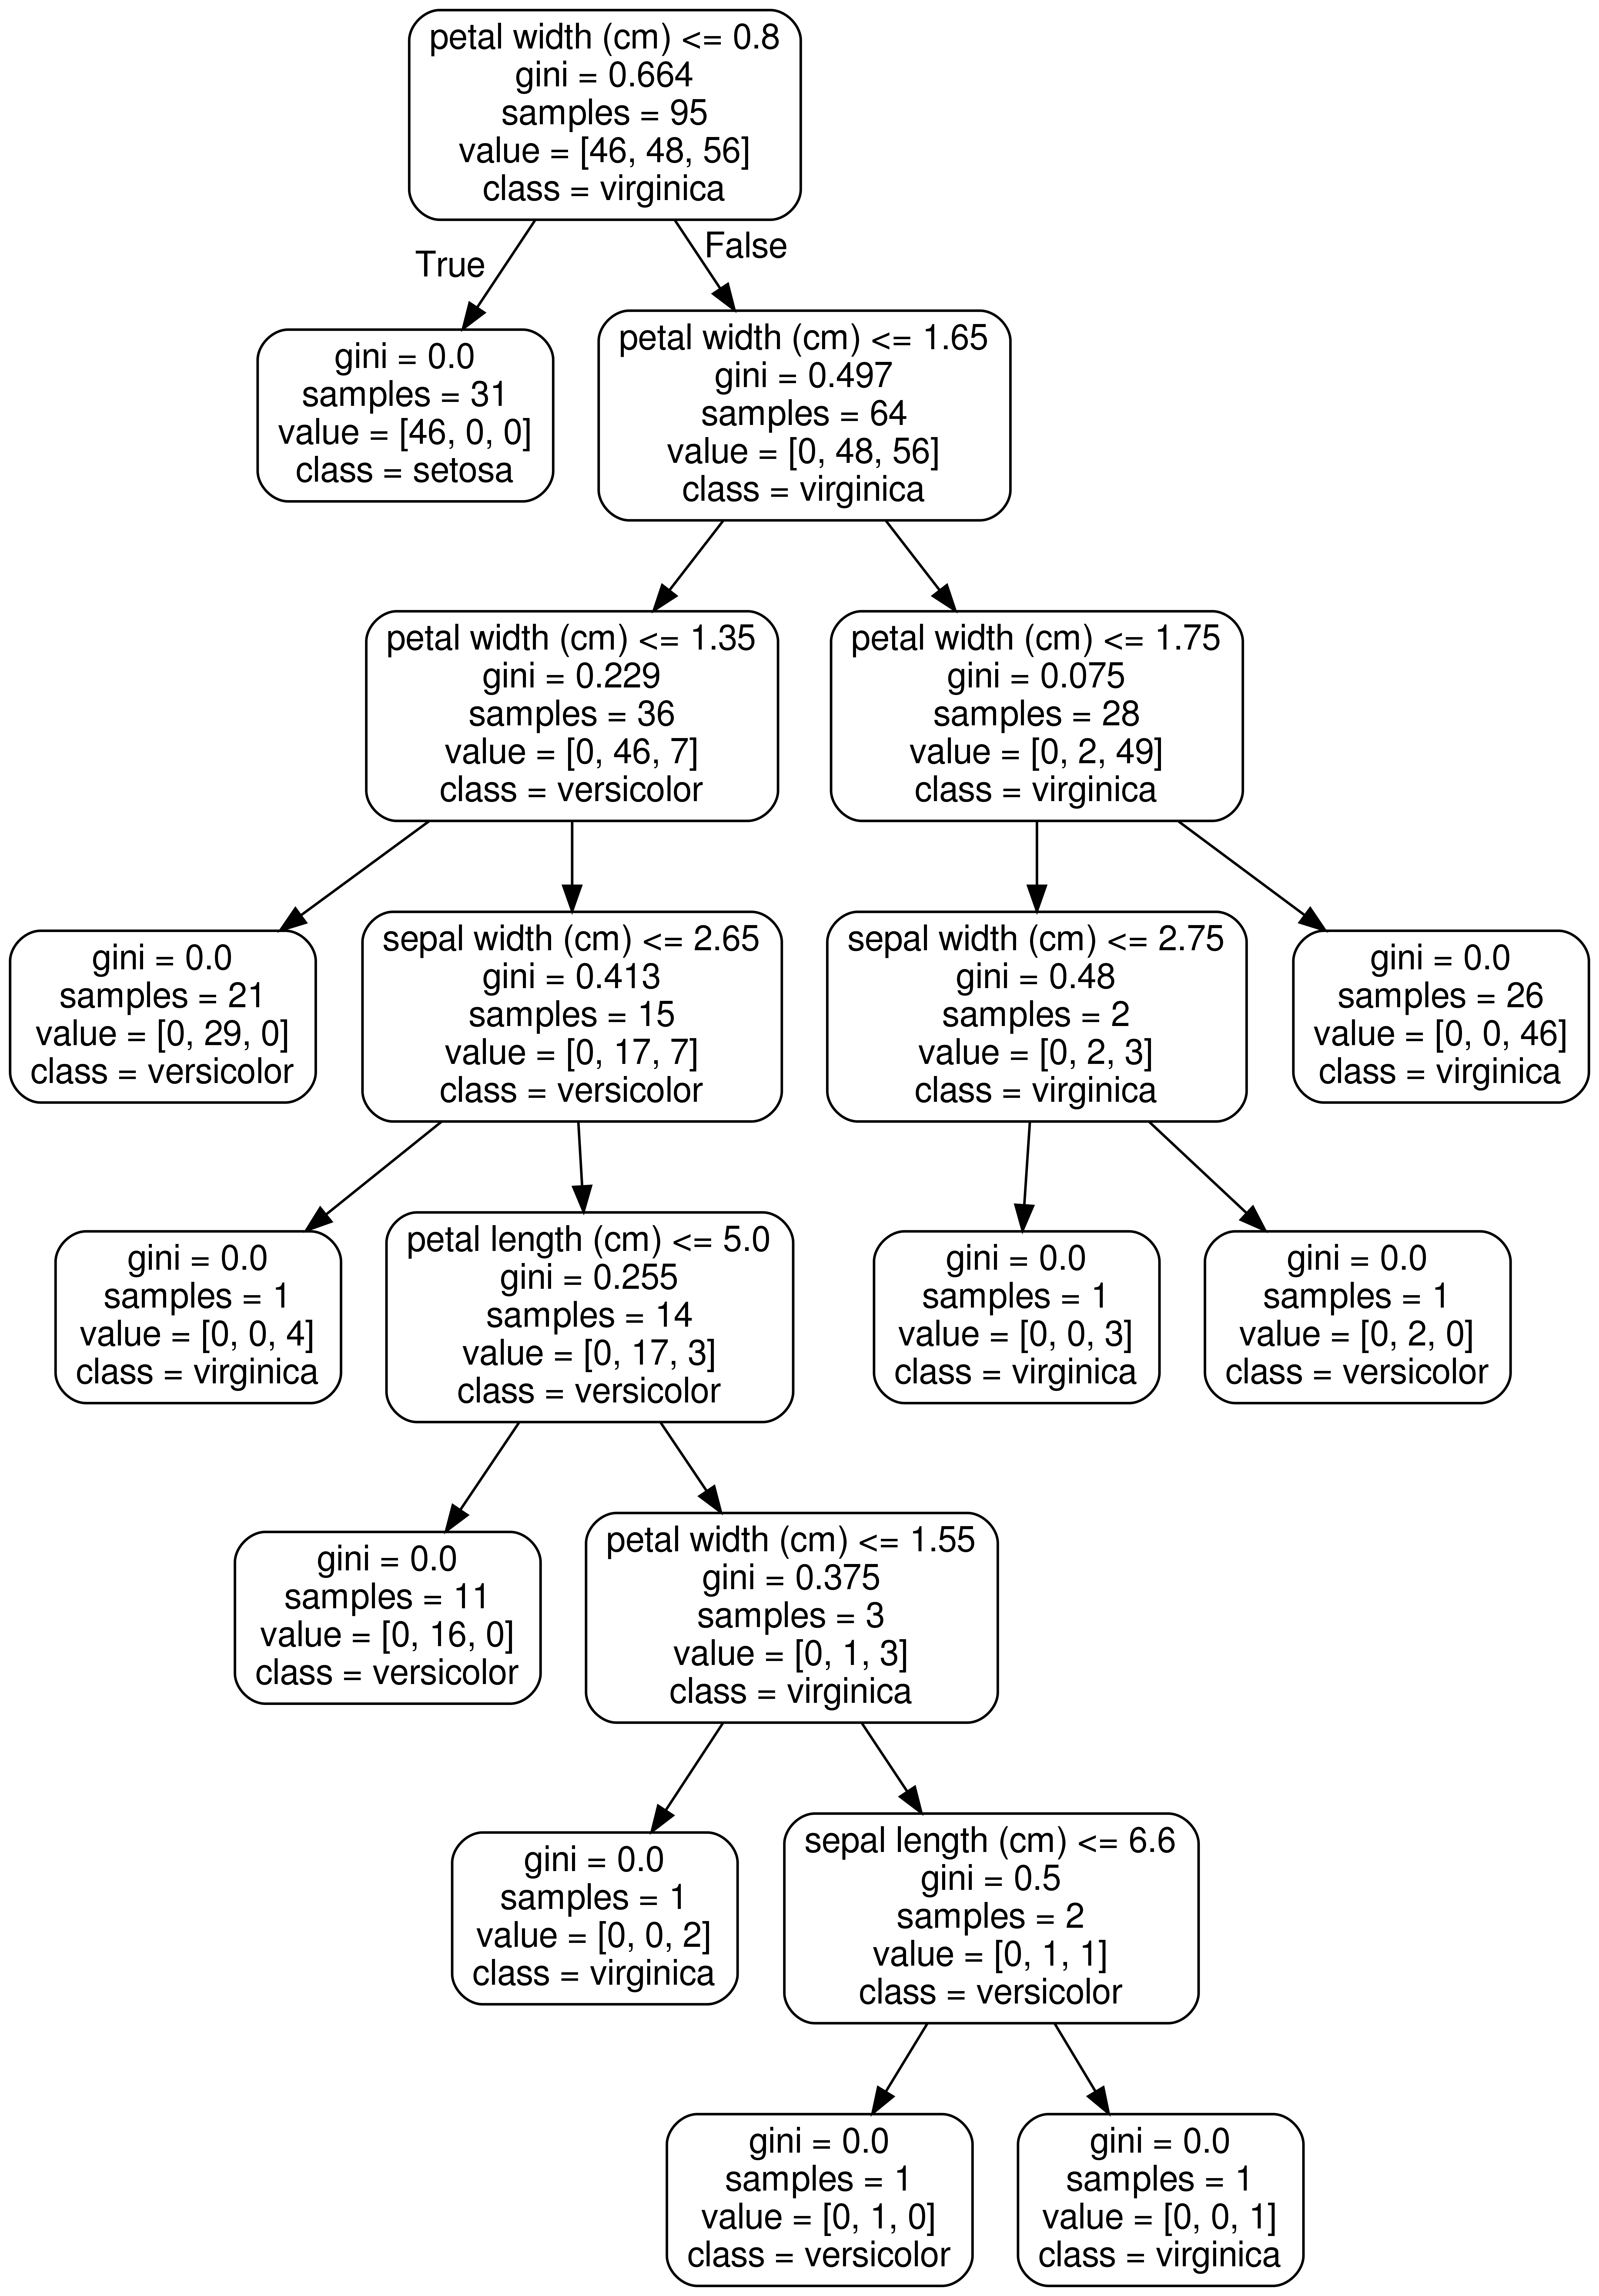

In [3]:
from IPython.display import Image
Image(filename='tree.png')

In [1]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive

data = load_wine()
X = data.data
y = data.target

labels = data.feature_names


def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter=split,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X, y)
    graph = Source(
        tree.export_graphviz(estimator,
                             out_file=None,
                             feature_names=labels,
                             class_names=['0', '1', '2'],
                             filled=True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter = interactive(plot_tree,
                    crit=['gini', 'entropy'],
                    split=['best', 'random'],
                    depth=[1, 2, 3, 4],
                    min_split=(0.1, 1),
                    min_leaf=(0.1, 0.5))
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# 回归
- `CART` 算法试图拆分训练数据，以最小化 `MSE`
$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{right}$$
- 缺点：倾向于正交边界，对训练数据的微小变动很敏感——使用`PCA`改善

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston

data = load_boston()
x, y = data.data, data.target
tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(x, y)

/home/yangbin7/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')